In [1]:
import sys

In [2]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install gym==0.25.1
!{sys.executable} -m pip install gym[classic_control]==0.25.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display
import ipywidgets as widgets
import time
import math
import random

from timeit import default_timer as timer
%matplotlib inline

In [4]:
env = gym.make("CartPole-v1",new_step_api=True)

In [5]:
class ObservationSpace:
  def __init__(self, observation_limits, observation_windows):
    self.window_size = np.asarray(observation_windows)
    self.shape = ((2 * np.asarray(observation_limits))/self.window_size).astype(int)
  
  def discreteState(self,state):
    return tuple((state/self.window_size + self.shape/2).astype(int))

## Functions

### Training and Testing Functions

#### Training Episode Function

In [132]:
def runEpisode(env, observation_space, q_table, learning_rate, discount, epsilon,  max_steps=500):
    state = observation_space.discreteState(env.reset())
    episode_score = 0
    for step in range(max_steps):

        # Decide an action

        if random.uniform(0, 1) > epsilon:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()

        observation, reward, terminated, _, _ = env.step(action)

        new_state = observation_space.discreteState(observation)

        episode_score += reward

        current_q = q_table[state][action]
        max_future_q = np.max(q_table[new_state])

        q_table[state][action] = (
            1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)

        state = new_state

        if terminated:
            break

    return q_table, episode_score


#### Train Model

In [131]:
class HyperParams:
    def __init__(self, learning_rate, discount, epsilon_decay, epsilon_max = float(1), epsilon_min = 0.05, epsilon_delay = 0):
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon_decay = epsilon_decay
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_delay = epsilon_delay

def trainModel(env, observation_space, episodes, hyper_params, start_episode=0, prev_q_table = None):
    hp = hyper_params
    q_table = q_table = np.random.uniform(-1,1,list(observation_space.shape)+ [env.action_space.n]) if prev_q_table is None else prev_q_table
    # q_table = q_table = np.empty(list(observation_space.shape)+ [env.action_space.n]) if prev_q_table is None else prev_q_table
    
    all_rewards = []
    epsilon = hp.epsilon_max
    previous_episode_score = -float('inf')

    for episode in range(start_episode, start_episode + episodes):

        q_table, episode_score = runEpisode(
            env, observation_space, q_table, hp.learning_rate, hp.discount, epsilon)

        all_rewards.append(episode_score)
        if epsilon > hp.epsilon_min and episode > hp.epsilon_delay and episode_score > previous_episode_score:
            epsilon = hp.epsilon_min + \
                (hp.epsilon_max - hp.epsilon_min) * \
                np.exp(-hp.epsilon_decay * (episode-hp.epsilon_delay))

    return q_table, all_rewards


#### Test Model

In [21]:
def testModel(env, observation_space, q_table, render=False, max_steps = 500):
  if render:
    env = gym.make("CartPole-v1", new_step_api = True, render_mode = 'human')
  test_reward = 0
  state = observation_space.discreteState(env.reset())
  for step in range(max_steps):
    if render:
      env.render()
    action = np.argmax(q_table[state])
    observation, reward, terminated, _, _ = env.step(action)
    state = observation_space.discreteState(observation)
    test_reward += reward
    if terminated:
      break
  return test_reward
  
def runTests(env, observation_space, q_table, num_tests):
  all_scores = []
  
  for i in range(num_tests):
    all_scores.append(testModel(env, observation_space, q_table, render = i == 0))
  
  average_score = np.mean(all_scores)
  return average_score
    

#### Train and Test

In [9]:
def trainAndTest(env, observation_space, episodes, test_interval, test_iterations, hyper_params):
  q_table = None
  current_episode = 0
  
  episode_array = [0]
  score_array = [0]
  rewards_array = []
  
  while current_episode < episodes:
    q_table, rewards = trainModel(env, observation_space, test_interval, hyper_params, current_episode, q_table )
    current_episode += test_interval
    
    
    episode_array.append(current_episode)
    score_array.append(runTests(env, observation_space, q_table, test_iterations))
    rewards_array.append(rewards)
    
  
  return  q_table, episode_array, score_array, rewards_array

### Experiment Function


In [10]:
def runExperiment(env, observation_space, parameter, experiment_space, training_event_per_interval, number_episodes, train_test_interval_size, test_iterations):

    

    hyper_params = HyperParams(0.8, 0.9, 0.0001)

    # setup progress bar
    learning_rate_scores = []
    test_progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=len(experiment_space),
        description='experiment value:',
        bar_style='info',
        style={'bar_color': 'red'},
        orientation='horizontal'
    )
    event_progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=training_event_per_interval,
        description='training event:',
        bar_style='info',
        style={'bar_color': 'red'},
        orientation='horizontal'
    )
    display(test_progress)
    display(event_progress)

    # run experiment

    experiment_results = []

    for experiment in range(len(experiment_space)):
        experiment_value = experiment_space[experiment]
        setattr(hyper_params, parameter, experiment_value)
        
        test_progress.value = experiment

        test_score = []

        x_axis = []
        for event in range(training_event_per_interval):

            _, x_axis, score, _ = trainAndTest(
                env, observation_space, number_episodes, train_test_interval_size, test_iterations, hyper_params)

            test_score.append(score)

            event_progress.value = event+1

        average_test_score = np.mean(test_score, 0)

        experiment_results.append(average_test_score)

        

    event_progress.close()
    test_progress.close()
    return experiment_results


### Result Plotting Functions

In [11]:
def plotResults(parameter, experiment_space, experiment_results, number_episodes, train_test_interval_size, x_axis_scale = 'linear'):
    experiment_intervals = math.ceil(
        number_episodes / train_test_interval_size)

    range_start_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=experiment_intervals,
        step=1,
        description='Start:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=False
    )
    range_end_slider = widgets.IntSlider(
        value=experiment_intervals,
        min=0,
        max=experiment_intervals,
        step=1,
        description='End:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=False
    )
    slice_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=experiment_intervals,
        step=1,
        description='Episode:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=False,
        readout_format='d'
    )

    def figureRange(x, y):
        for test in range(len(experiment_space)):
            plt.plot(np.arange(x*train_test_interval_size, y*train_test_interval_size, train_test_interval_size),
                     np.asarray(experiment_results)[test][x:y], label=experiment_space[test])
        plt.legend(title="Training Event", bbox_to_anchor=(1, 1))
        plt.title(parameter)
        plt.show()

        range_end_slider.min = x+1
        range_start_slider.max = y-1

    

    def plotSlice(x):
        slice = np.asarray(experiment_results)[:, x]
        figure, axes = plt.subplots()
        axes.plot(experiment_space[:], slice)
        axes.set_xscale(x_axis_scale)
        axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        plt.title("{0} vs Score at Episode {1}".format(parameter, x*train_test_interval_size))
        plt.xlabel("{0}".format(parameter))

        plt.ylabel("Score at episode")
        plt.show()

    widgets.interact(figureRange, x=range_start_slider, y=range_end_slider)
    widgets.interact(plotSlice, x=slice_slider)  

    figure, axes = plt.subplots()
    axes.plot(experiment_space[:], experiment_results)
    axes.set_xscale(x_axis_scale)
    axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.title("{0} vs Score at episode (All)".format(parameter))
    plt.xlabel("{0}".format(parameter))
    plt.ylabel("Score at episode")
    plt.show()


## Testing

In [12]:
observation_limits = [2.5,5,0.5,5]
observation_windows = [0.05,0.1,0.01,0.1]

env = gym.make("CartPole-v1", new_step_api=True)
observation_space = ObservationSpace(observation_limits, observation_windows)
hyper_params = HyperParams(0.2,0.99,0.0001)

# Run Experiment



experiment_intervals = 3
training_event_per_interval = 1

number_episodes = 30000
train_test_interval_size = 1000
test_iterations = 10

# hyper parameters

parameter = "learning_rate"
max_experiment_value = 0.1
min_experiment_value = 1
experiment_space = np.linspace(
        min_experiment_value, max_experiment_value, num = experiment_intervals)


# results = runExperiment(env, observation_space, parameter, experiment_space, training_event_per_interval, number_episodes, train_test_interval_size, test_iterations)


In [13]:
# plotResults("learning_rate", experiment_space, results,
#             number_episodes, train_test_interval_size)


In [137]:
observation_limits = [3,5,0.6,5]
observation_windows = [0.5,0.5,0.02,0.2]

env = gym.make("CartPole-v1", new_step_api=True)
observation_space = ObservationSpace(observation_limits, observation_windows)
print(observation_space.shape)
hyper_params = HyperParams(0.3,0.99,0.00001, epsilon_delay=1000)


[12 20 60 50]


In [144]:
q_table, episode_array, score_array, rewards_array = trainAndTest(env,observation_space, 10000, 100, 10, hyper_params)
env.close()

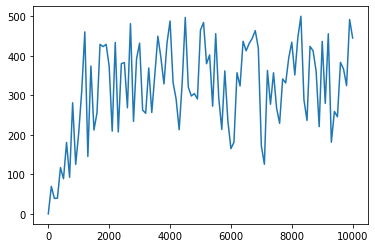

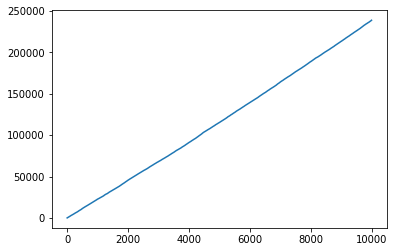

In [145]:
plt.plot(episode_array, score_array)
plt.show()
plt.plot(np.cumsum((rewards_array)))